In [29]:
from hossam import *
from pandas import DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.base import BaseEstimator, TransformerMixin


# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# 보팅 회귀
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

from sklearn.ensemble import BaggingRegressor

from sklearn.neighbors import KNeighborsRegressor

import pickle

In [30]:
from IPython.display import display


class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0, check_cols=None):
        self.threshold = threshold
        self.check_cols = check_cols

    def _compute_vifs(self, X: DataFrame):
        exog = sm.add_constant(X, prepend=True)
        vifs = {}

        for i, col in enumerate(X.columns):
            try:
                vifs[col] = float(variance_inflation_factor(exog.values, i + 1))
            except Exception:
                vifs[col] = float("inf")

        vdf = DataFrame(vifs.items(), columns=["Variable", "VIF"])
        return vdf.sort_values("VIF", ascending=False)

    def fit(self, X, y=None):
        df = X.copy().dropna()
        self.vif_cols_ = self.check_cols if self.check_cols else df.columns.tolist()
        X_vif = df[self.vif_cols_].copy()
        self.drop_cols_ = []
        i = 0

        while True:
            if X_vif.shape[1] == 0:
                break

            print(f"\nVIF 제거 반복 {i+1}회차 ====================")
            vdf = self._compute_vifs(X_vif)
            max_vif = vdf.iloc[0]["VIF"]
            max_col = vdf.iloc[0]["Variable"]

            if max_vif <= self.threshold:
                print(
                    "모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 {0}개.".format(
                        i
                    )
                )
                break

            X_vif = X_vif.drop(columns=[max_col])
            self.drop_cols_.append(max_col)
            print(f"제거된 변수: {max_col} (VIF={max_vif:.2f})")
            i += 1

        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols_, errors="ignore")

In [31]:
def hs_learning_cv(
    estimator,
    x,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    """학습 곡선 분석 및 과적합 판정"""
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52,
    )

    if hasattr(estimator, "named_steps"):
        classname = estimator.named_steps["model"].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    # neg RMSE → RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지점 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]

    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv

    # 과소적합 기준선
    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))
    std_y = y.std()
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))
    some_threshold = min(rmse_naive, std_y, rmse_r2)

    # 판정 로직
    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = "과소적합 (bias 큼)"
    elif gap_ratio <= 0.8:
        status = "과대적합 (variance 큼)"
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = "일반화 양호"
    elif var_ratio > 0.15:
        status = "데이터 부족 / 분산 큼"
    else:
        status = "판단 유보"

    # 결과 DataFrame
    result_df = DataFrame(
        {
            "Train RMSE": [final_train],
            "CV RMSE 평균": [final_cv],
            "CV RMSE 표준편차": [final_std],
            "Train/CV 비율": [gap_ratio],
            "CV 변동성 비율": [var_ratio],
            "판정 결과": [status],
        },
        index=[classname],
    )

    # 학습곡선 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, "o-", label="Train RMSE")
    plt.fill_between(train_sizes, train_mean - cv_std, train_mean + cv_std, alpha=0.1)
    plt.plot(train_sizes, cv_mean, "o-", label="CV RMSE")
    plt.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1)
    plt.xlabel("Training Size")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve: {classname}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return result_df

In [32]:
def hs_leanring_cv(
    estimator,
    x,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52,
    )

    model_name = estimator.named_steps["model"].__class__.__name__
    print(f"=== Learning Curve: {model_name} ===")

    # neg RMSE → RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지점 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]

    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv

    # 과소적합 기준선
    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))
    std_y = y.std()
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))
    some_threshold = min(rmse_naive, std_y, rmse_r2)

    # 판정 로직
    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = "과소적합 (bias 큼)"
    elif gap_ratio <= 0.8:
        status = "과대적합 (variance 큼)"
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = "일반화 양호"
    elif var_ratio > 0.15:
        status = "데이터 부족 / 분산 큼"
    else:
        status = "판단 유보"

    # 정량 결과 표
    result_df = DataFrame(
        {
            "지표": [
                "Train RMSE",
                "CV RMSE 평균",
                "CV RMSE 표준편차",
                "Train/CV 비율",
                "CV 변동성 비율",
                "판정 결과",
            ],
            "값": [
                final_train,
                final_cv,
                final_std,
                gap_ratio,
                var_ratio,
                status,
            ],
        }
    )
    display(result_df)

    # 학습곡선 시각화
    figsize = (1280 / my_dpi, 720 / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.lineplot(
        x=train_sizes,
        y=train_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )

    sb.lineplot(
        x=train_sizes,
        y=cv_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="CV RMSE",
    )

    ax.set_xlabel("훈련 데이터 수", fontsize=8, labelpad=5)
    ax.set_ylabel("RMSE", fontsize=8, labelpad=5)
    ax.set_title("학습곡선 (Learning Curve)", fontsize=12, pad=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

In [33]:
def hs_get_scores(estimator, x_test, y_true):
    """모델 성능 평가 함수"""
    if hasattr(estimator, "named_steps"):
        classname = estimator.named_steps["model"].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    y_pred = estimator.predict(x_test)

    return DataFrame(
        {
            "결정계수(R2)": r2_score(y_true, y_pred),
            "평균절대오차(MAE)": mean_absolute_error(y_true, y_pred),
            "평균제곱오차(MSE)": mean_squared_error(y_true, y_pred),
            "평균오차(RMSE)": np.sqrt(mean_squared_error(y_true, y_pred)),
            "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(
                y_true, y_pred
            ),
            "평균 비율 오차(MPE)": np.mean((y_true - y_pred) / y_true * 100),
        },
        index=[classname],
    )

In [34]:
def hs_get_score_cv(
    estimator,
    x_test,
    y_test,
    x_origin,
    y_origin,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    """성능평가와 과적합 판정을 동시에 수행"""
    score_df = hs_get_scores(estimator, x_test, y_test)
    cv_df = hs_learning_cv(
        estimator,
        x_origin,
        y_origin,
        scoring=scoring,
        cv=cv,
        train_sizes=train_sizes,
        n_jobs=n_jobs,
    )
    return merge(score_df, cv_df, left_index=True, right_index=True)

In [35]:
origin = load_data("restaurant_sales_preprocessed")
origin.set_index("date", inplace=True)
origin["holiday"] = origin["holiday"].astype("category")
origin["weekend"] = origin["weekend"].astype("category")
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


In [36]:
df = origin
yname = "sales"

x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

In [37]:
score_df = DataFrame(
    [
        [
            "Linear",
            0.709,
            0.156,
            0.042,
            0.204,
            0.010,
            0.225,
            0.198,
            0.203,
            0.012,
            0.973,
            0.060,
            "⚠️ 판단 유보",
        ],
        [
            "Ridge",
            0.708,
            0.156,
            0.042,
            0.205,
            0.010,
            0.219,
            0.198,
            0.203,
            0.012,
            0.974,
            0.058,
            "⚠️ 판단 유보",
        ],
        [
            "Lasso",
            0.707,
            0.155,
            0.042,
            0.205,
            0.009,
            0.221,
            0.199,
            0.204,
            0.011,
            0.978,
            0.055,
            "⚠️ 판단 유보",
        ],
        [
            "ElasticNet",
            0.709,
            0.156,
            0.042,
            0.204,
            0.010,
            0.223,
            0.198,
            0.203,
            0.012,
            0.974,
            0.059,
            "⚠️ 판단 유보",
        ],
        [
            "SGD",
            0.700,
            0.160,
            0.043,
            0.207,
            0.010,
            0.229,
            0.203,
            0.210,
            0.010,
            0.964,
            0.046,
            "⚠️ 판단 유보",
        ],
        [
            "KNN",
            0.635,
            0.178,
            0.052,
            0.229,
            0.011,
            0.301,
            0.000,
            0.220,
            0.020,
            0.000,
            0.090,
            "⚠️ 과대적합 (variance 큼)",
        ],
        [
            "DecisionTree",
            0.620,
            0.196,
            0.054,
            0.233,
            0.012,
            0.353,
            0.224,
            0.245,
            0.018,
            0.912,
            0.072,
            "✅ 일반화 양호",
        ],
        [
            "SVR",
            0.701,
            0.157,
            0.043,
            0.207,
            0.010,
            0.233,
            0.196,
            0.206,
            0.011,
            0.949,
            0.055,
            "✅ 일반화 양호",
        ],
    ],
    columns=[
        "모델",
        "결정계수(R2)",
        "MAE",
        "MSE",
        "RMSE",
        "MAPE",
        "MPE",
        "Train RMSE",
        "CV RMSE 평균",
        "CV RMSE 표준편차",
        "Train/CV 비율",
        "CV 변동성 비율",
        "판정 결과",
    ],
)
score_df

,모델,결정계수(R2),MAE,MSE,RMSE,MAPE,MPE,Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
0,Linear,0.709,0.156,0.042,0.204,0.010,0.225,0.198,0.203,0.012,0.973,0.060,⚠️ 판단 유보
1,Ridge,0.708,0.156,0.042,0.205,0.010,0.219,0.198,0.203,0.012,0.974,0.058,⚠️ 판단 유보
2,Lasso,0.707,0.155,0.042,0.205,0.009,0.221,0.199,0.204,0.011,0.978,0.055,⚠️ 판단 유보
3,ElasticNet,0.709,0.156,0.042,0.204,0.010,0.223,0.198,0.203,0.012,0.974,0.059,⚠️ 판단 유보
4,SGD,0.700,0.160,0.043,0.207,0.010,0.229,0.203,0.210,0.010,0.964,0.046,⚠️ 판단 유보
5,KNN,0.635,0.178,0.052,0.229,0.011,0.301,0.000,0.220,0.020,0.000,0.090,⚠️ 과대적합 (variance 큼)
6,DecisionTree,0.620,0.196,0.054,0.233,0.012,0.353,0.224,0.245,0.018,0.912,0.072,✅ 일반화 양호
7,SVR,0.701,0.157,0.043,0.207,0.010,0.233,0.196,0.206,0.011,0.949,0.055,✅ 일반화 양호


In [38]:
df = score_df.copy()

# ① 학습–검증 괴리
cond_train_cv = df["Train/CV 비율"] <= 0.95

# ② 교차검증 불안정성
cond_cv_var = df["CV 변동성 비율"] >= 0.07

# ③ 정성 판정 (텍스트)
cond_text = df["판정 결과"].str.contains("variance|과대적합", regex=True)

# ④ 모델 특성 (고분산 구조)
cond_model_type = df["모델"].str.contains("KNN|Tree", regex=True)

# 배깅 후보 여부
df["배깅_후보"] = cond_train_cv | cond_cv_var | cond_text | cond_model_type

# 배깅 후보만 추출
bagging_candidates = (
    df[df["배깅_후보"]]
    .sort_values(by=["CV 변동성 비율", "Train/CV 비율"], ascending=[False, True])
    .reset_index(drop=True)
)

bagging_candidates

,모델,결정계수(R2),MAE,MSE,RMSE,MAPE,MPE,Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과,배깅_후보
0,KNN,0.635,0.178,0.052,0.229,0.011,0.301,0.000,0.220,0.020,0.000,0.090,⚠️ 과대적합 (variance 큼),True
1,DecisionTree,0.620,0.196,0.054,0.233,0.012,0.353,0.224,0.245,0.018,0.912,0.072,✅ 일반화 양호,True
2,SVR,0.701,0.157,0.043,0.207,0.010,0.233,0.196,0.206,0.011,0.949,0.055,✅ 일반화 양호,True


In [39]:
%%time

# 파이프라인 정의
pipe = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor(n_jobs=-1))])

# 하이퍼파라미터 그리드
param_grid = {
    # 핵심 파라미터 ⭐⭐⭐
    "model__n_neighbors": [3, 5, 7, 9, 15, 25],
    "model__weights": ["uniform", "distance"],

    # 거리 정의 ⭐⭐
    "model__metric": ["euclidean", "manhattan", "minkowski"],
    "model__p": [
        1,
        2,
    ],  # p=1: Manhattan, p=2: Euclidean -> metric="minkowski"일 때만 p 의미 있음

    # 탐색 알고리즘 / 성능
    "model__algorithm": ["auto", "ball_tree", "kd_tree"],
    "model__leaf_size": [20, 30, 40],
}

# GridSearchCV 설정
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1)

# 학습
gs.fit(x_train, y_train)

# 최적 모델
best_model = gs.best_estimator_

# 학습 모델 저장
with open("knn.pkl", "wb") as f:
    pickle.dump(best_model, f)

# 결과 확인
print("Best params:", gs.best_params_)
print("CV best score:", gs.best_score_)


Best params: {'model__algorithm': 'auto', 'model__leaf_size': 20, 'model__metric': 'euclidean', 'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'distance'}
CV best score: 0.6444866391028172
CPU times: user 445 ms, sys: 28.3 ms, total: 473 ms
Wall time: 5.3 s


In [40]:
with open("knn.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# -------------------------
# 1) BaggingRegressor 정의
# -------------------------
bagging = BaggingRegressor(
    estimator=loaded_model,
    bootstrap=True,
    random_state=52,
    n_jobs=-1,
)

# -------------------------
# 2) Bagging 하이퍼파라미터 그리드
# -------------------------
param_grid = {
    "n_estimators": [10, 30, 50, 100],
    "max_samples": [0.5, 0.7, 1.0],
    "max_features": [0.5, 0.7, 1.0],
}

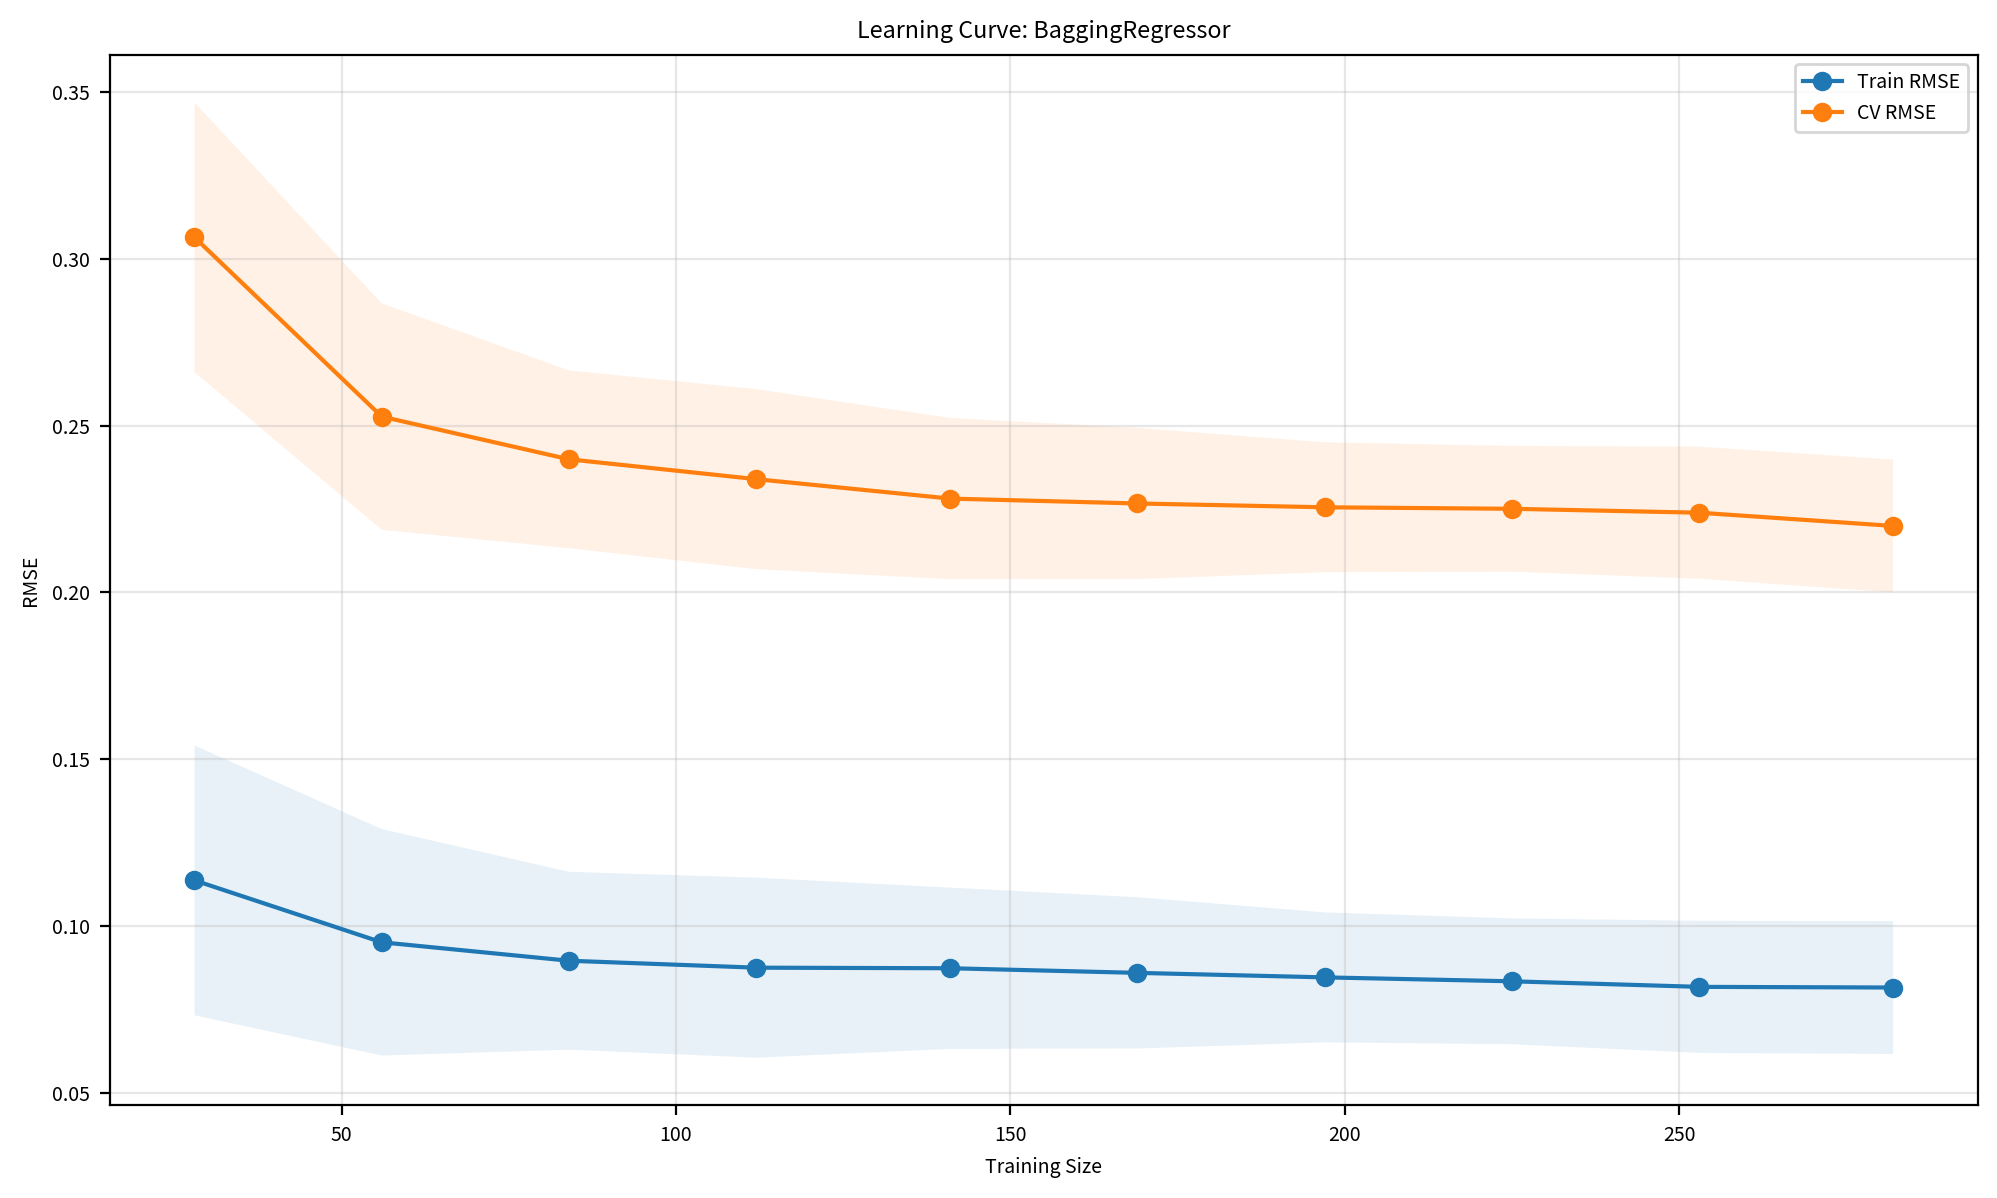

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
BaggingRegressor,0.955512,0.063165,0.006504,0.080645,0.003857,0.029307,0.081546,0.21992,0.019914,0.370801,0.090553,과대적합 (variance 큼)


In [41]:
# -------------------------
# 3) GridSearchCV
# -------------------------
bagging_gs = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)

# -------------------------
# 4) 학습
# -------------------------
bagging_gs.fit(x_train, y_train)
best_bagging_model = bagging_gs.best_estimator_
hs_get_score_cv(best_bagging_model, x_train, y_train, x, y)